In [23]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge

from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.impute import KNNImputer


In [24]:
# Prepare the graduate data
df_grad = pd.read_csv('/Users/leslie/Desktop/Leslie Level Up/project/Graduate Map 20230614004041/Graduate Data.csv')

# Take a peek at the data
df_grad.head()

,region,school,graduates_2019,graduates_2014,median_debt,median_income,debt_to_earnings_ratio,white_pct,aian_pct,asian_pct,...,inst_net_price,inst_net_price_30k,inst_floan_pct,inst_median_debt,inst_completion_rate,inst_econ_mobility_rate,inst_lowinc_to_highinc,inst_inc_6yr,inst_inc_10yr,inst_inc_10yr_grad
0,"Abilene, TX",Abilene Christian University,1326,1122,25712,42682,0.602,0.661,0.004,0.014,...,26809,24153,0.913,24000,0.474,0.014,0.274,32600,49294,44511
1,"Abilene, TX",Cisco College,722,624,Data Unavailable,Data Unavailable,Data Unavailable,0.537,0.010,0.019,...,8650,8263,0.373,Data Unavailable,0.112,0.029,0.158,27980,35849,32856
2,"Abilene, TX",Hardin-Simmons University,539,516,26500,36141,0.733,0.657,0.002,0.013,...,19509,16627,0.891,24644,0.383,0.014,0.233,36413,46447,46176
3,"Abilene, TX",Howard Payne University,231,211,27000,32925,0.820,0.652,0.004,0.009,...,22178,16048,0.934,25000,0.226,0.021,0.203,34831,43756,40848
4,"Abilene, TX",McMurry University,154,230,27000,35060,0.770,0.524,0.000,0.020,...,21450,17194,0.912,27000,0.281,0.028,0.207,36438,45756,44289


## EAD

### Investigation of structure, quality and content

In [25]:
# Show size of the dataset
df_grad.shape

(5901, 45)

In [26]:
# Count the number of each data type
pd.value_counts(df_grad.dtypes)

object     30
float64     9
int64       6
dtype: int64

In [27]:
# Structure of non-numerical features
df_grad.describe(exclude='number')

,region,school,median_debt,median_income,debt_to_earnings_ratio,inst_location,inst_type,inst_classification,inst_special_designations,int_pct_online,...,inst_net_price,inst_net_price_30k,inst_floan_pct,inst_median_debt,inst_completion_rate,inst_econ_mobility_rate,inst_lowinc_to_highinc,inst_inc_6yr,inst_inc_10yr,inst_inc_10yr_grad
count,5901,5901,5901,5901,5901,5901,5901,5901,903,5901,...,5901,5901,5901,5901,5901,5901,5901,5901,5901,5901
unique,573,5846,2127,2085,1023,2662,3,13,27,864,...,4754,4671,782,1819,917,83,528,3652,3716,502
top,"New York-Newark-Jersey City, NY-NJ-PA",Columbia College,Data Unavailable,Data Unavailable,Data Unavailable,"New York, New York","Private, For-profit",Data Unavailable,Hispanic-serving Institution,0.000,...,Data Unavailable,Data Unavailable,Data Unavailable,Data Unavailable,Data Unavailable,0.022,0.096,Data Unavailable,Data Unavailable,30747
freq,377,4,1445,1019,1635,75,2168,2952,380,2747,...,695,748,1675,1350,899,2095,2038,1324,1330,2033


In [28]:
# Review the numeric columns
num_list = df_grad.select_dtypes(include=np.number).columns.tolist()
print(f'Numeric columns: {num_list}')

Numeric columns: ['graduates_2019', 'graduates_2014', 'white_pct', 'aian_pct', 'asian_pct', 'black_pct', 'hisp_pct', 'unkn_pct', 'two_plus_pct', 'men_pct', 'women_pct', 'graduates_2018', 'graduates_2017', 'graduates_2016', 'graduates_2015']


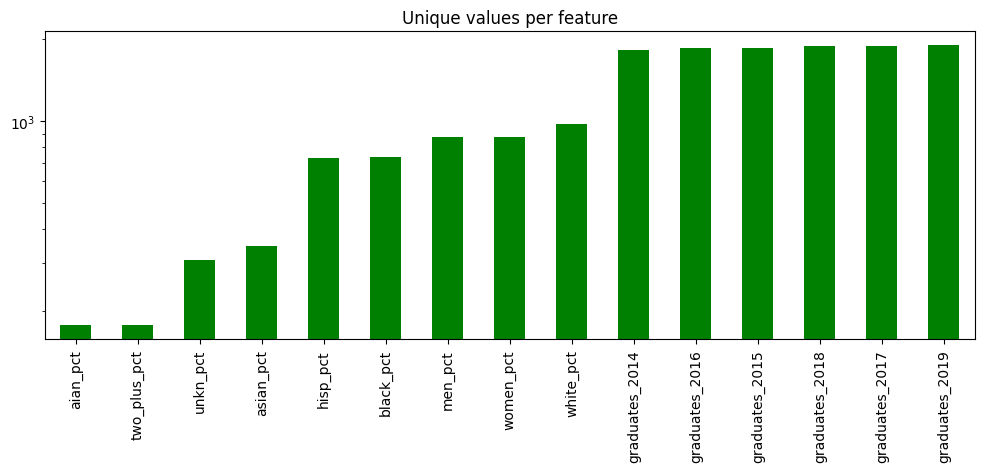

In [29]:
# Structure of numeric columns
unique_val = df_grad.select_dtypes(include='number').nunique().sort_values()
unique_val.plot.bar(logy=True, 
                    figsize=(12,4), 
                    title='Unique values per feature', color='g');

### Data cleaning 

In [30]:
# Replace unavailable data with nan 
df_grad = df_grad.replace('Data Unavailable', np.nan)

In [31]:
df_grad.shape

(5901, 45)

In [32]:
# Drop rows with unavailable economonic mobility rate data
index_eco = df_grad[df_grad['inst_econ_mobility_rate']=='Data Unavailable'].index
df_grad.drop(index_eco, inplace=True)

In [33]:
# Check the filtered data frame shape
df_grad.shape

(5901, 45)

In [34]:
df_grad.columns[2:]

Index(['graduates_2019', 'graduates_2014', 'median_debt', 'median_income',
       'debt_to_earnings_ratio', 'white_pct', 'aian_pct', 'asian_pct',
       'black_pct', 'hisp_pct', 'unkn_pct', 'two_plus_pct', 'men_pct',
       'women_pct', 'graduates_2018', 'graduates_2017', 'graduates_2016',
       'graduates_2015', 'inst_location', 'inst_type', 'inst_classification',
       'inst_special_designations', 'int_pct_online', 'inst_undergrads',
       'inst_undergrads_nondeg', 'inst_pell', 'inst_low_inc_pct',
       'inst_undergrad_women_pct', 'inst_undergrad_nonwhite_pct', 'inst_grads',
       'inst_tuition_instate', 'inst_tuition_outstate', 'inst_coa',
       'inst_net_price', 'inst_net_price_30k', 'inst_floan_pct',
       'inst_median_debt', 'inst_completion_rate', 'inst_econ_mobility_rate',
       'inst_lowinc_to_highinc', 'inst_inc_6yr', 'inst_inc_10yr',
       'inst_inc_10yr_grad'],
      dtype='object')

In [35]:
# Convert columns to numeric format
cols = ['median_debt', 'median_income', 'debt_to_earnings_ratio', 'int_pct_online',
        'inst_undergrads', 'inst_undergrads_nondeg', 'inst_pell', 'inst_low_inc_pct',
         'inst_undergrad_women_pct', 'inst_undergrad_nonwhite_pct', 'inst_grads',
          'inst_tuition_instate', 'inst_tuition_outstate', 'inst_coa', 'inst_net_price',
          'inst_net_price_30k', 'inst_floan_pct', 'inst_median_debt', 'inst_completion_rate',
           'inst_econ_mobility_rate', 'inst_lowinc_to_highinc', 'inst_inc_6yr', 'inst_inc_10yr',
            'inst_inc_10yr_grad' ]
df_grad[cols] = df_grad[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [36]:
df_grad.dtypes

region                          object
school                          object
graduates_2019                   int64
graduates_2014                   int64
median_debt                    float64
median_income                  float64
debt_to_earnings_ratio         float64
white_pct                      float64
aian_pct                       float64
asian_pct                      float64
black_pct                      float64
hisp_pct                       float64
unkn_pct                       float64
two_plus_pct                   float64
men_pct                        float64
women_pct                      float64
graduates_2018                   int64
graduates_2017                   int64
graduates_2016                   int64
graduates_2015                   int64
inst_location                   object
inst_type                       object
inst_classification             object
inst_special_designations       object
int_pct_online                 float64
inst_undergrads          

### Quality investigation

In [37]:
# Check duplicates
n_duplicates = df_grad.duplicated().sum()
print(f'We have {n_duplicates} duplicates in the dataset.')

We have 0 duplicates in the dataset.


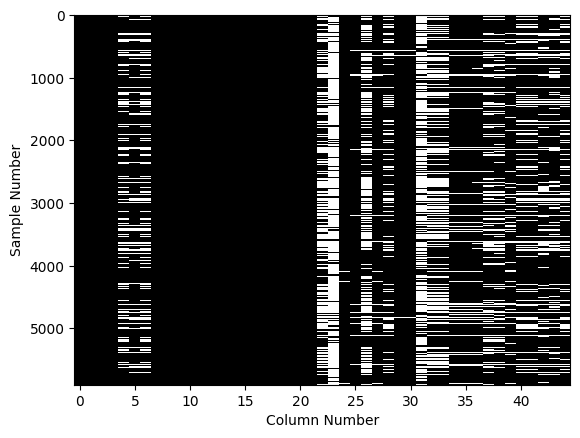

In [38]:
# Look at missing values per sample
plt.imshow(df_grad.isna(), aspect='auto',
           interpolation='nearest', cmap='gray')
plt.xlabel('Column Number')
plt.ylabel('Sample Number');

The figure shows on the y-xis each of 4,654 individual samples, and on the x-axis if any of the 46 features contains a missing value. 

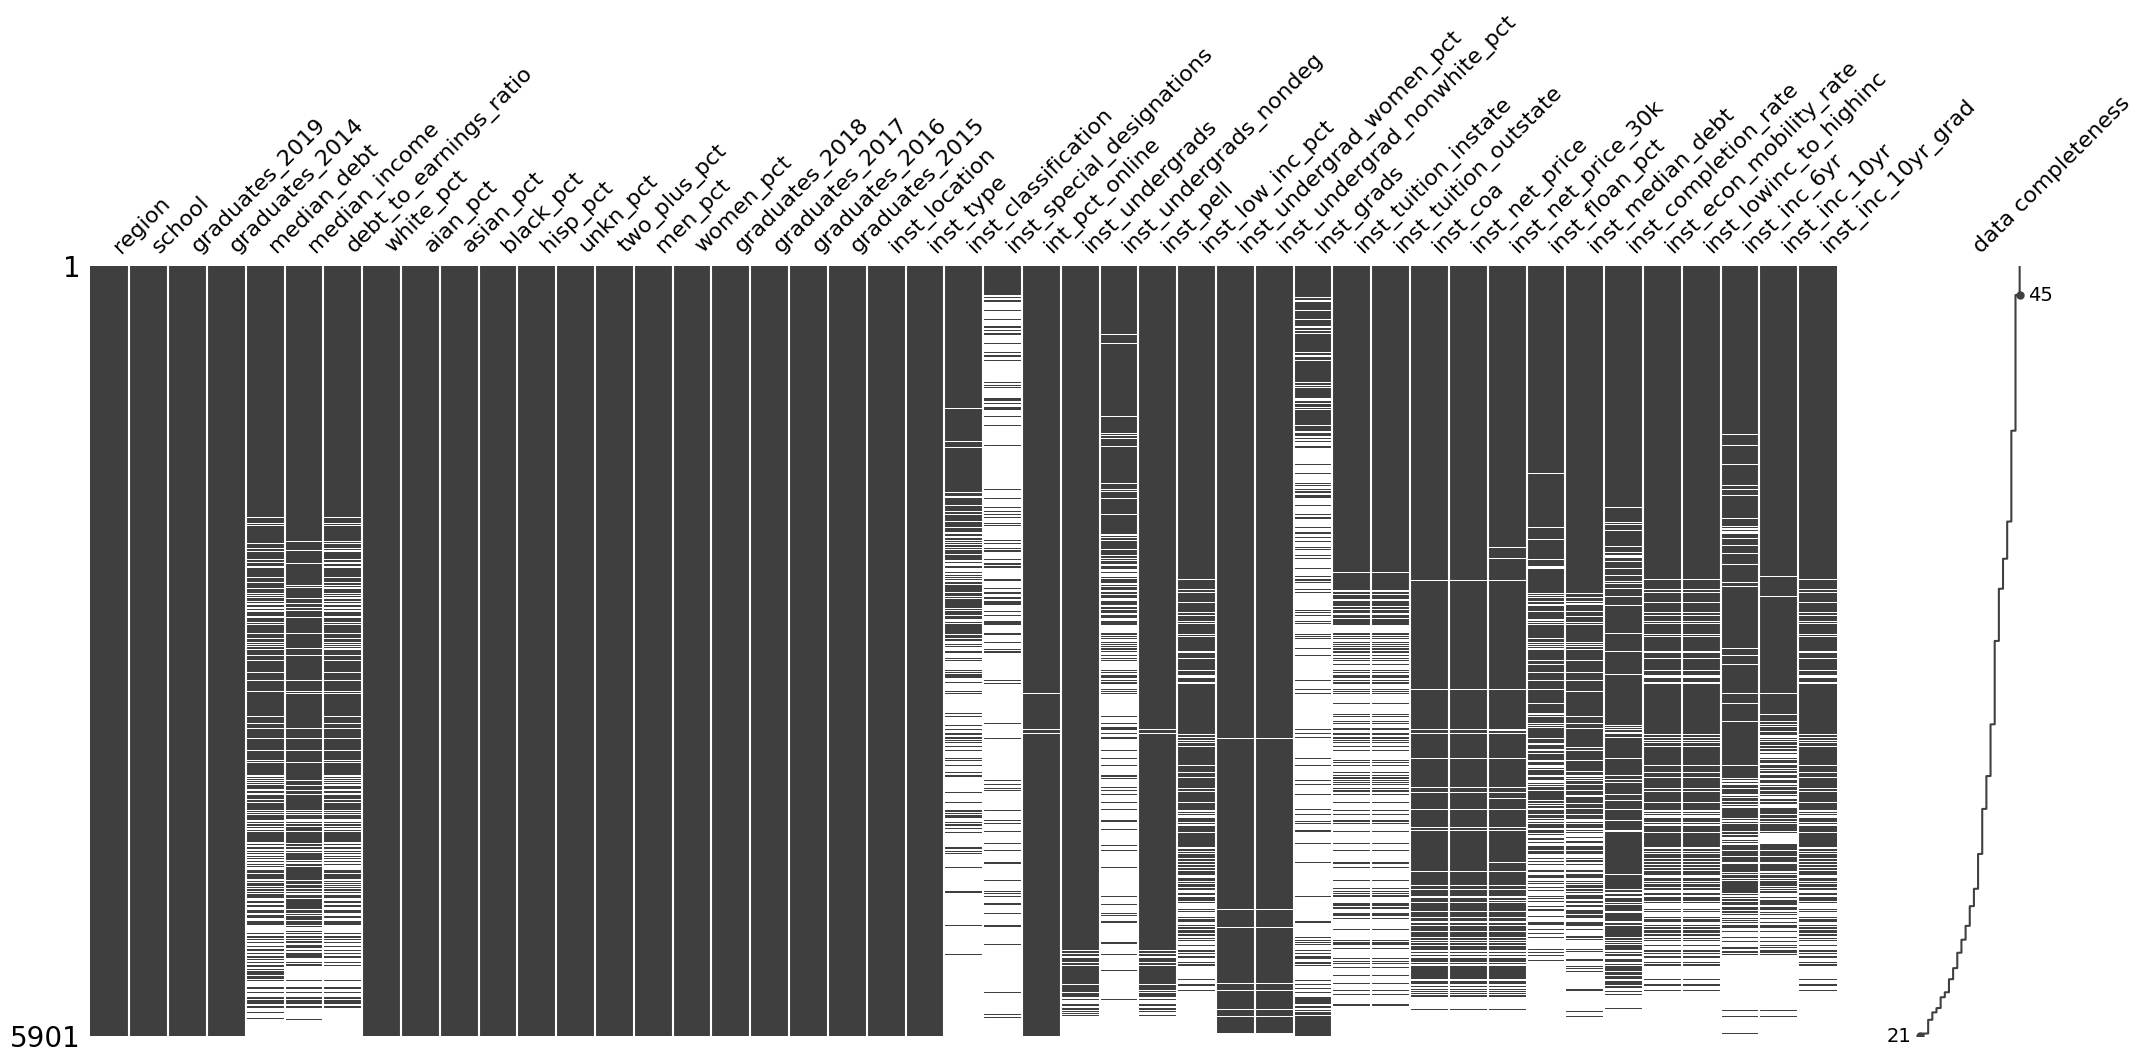

In [39]:
# Visualize the missing values per sample in a more readable way
msno.matrix(df_grad, labels=True, sort='descending');

The two plots above indicated a significant gap in the dataset due to some samples with over 50% missing feature values. Consequently, it is not advisable to merely fill these gaps with replacement values. We will drop samples with more than 20% missing values, based on the information provided in the "Data Completness" column. 

In [40]:
df_grad = df_grad.dropna(thresh=df_grad.shape[1] * 0.80,
                          axis=0).reset_index(drop=True)
df_grad.shape

(4505, 45)

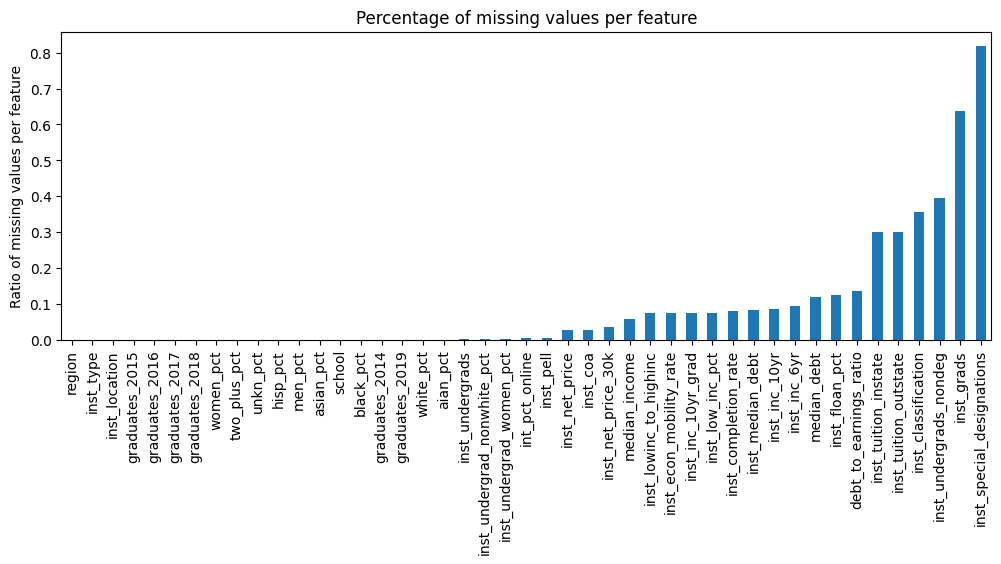

In [41]:
# Look at missing values per feature
df_grad.isna().mean().sort_values().plot(
    kind='bar', figsize=(12,4),
    title='Percentage of missing values per feature',
    ylabel='Ratio of missing values per feature');

As shown above, most features don't contain any missing values in contrast to features such as *inst_sepcial_designations, inst_grades, inst_undergrads_nondeg* still contain lot of missing values. We will go ahead remove features with more than 15% of missing values.

In [42]:
df_grad = df_grad.dropna(thresh=df_grad.shape[0] * 0.85, axis=1)

df_grad.shape

(4505, 39)

In [43]:
df_grad.columns

Index(['region', 'school', 'graduates_2019', 'graduates_2014', 'median_debt',
       'median_income', 'debt_to_earnings_ratio', 'white_pct', 'aian_pct',
       'asian_pct', 'black_pct', 'hisp_pct', 'unkn_pct', 'two_plus_pct',
       'men_pct', 'women_pct', 'graduates_2018', 'graduates_2017',
       'graduates_2016', 'graduates_2015', 'inst_location', 'inst_type',
       'int_pct_online', 'inst_undergrads', 'inst_pell', 'inst_low_inc_pct',
       'inst_undergrad_women_pct', 'inst_undergrad_nonwhite_pct', 'inst_coa',
       'inst_net_price', 'inst_net_price_30k', 'inst_floan_pct',
       'inst_median_debt', 'inst_completion_rate', 'inst_econ_mobility_rate',
       'inst_lowinc_to_highinc', 'inst_inc_6yr', 'inst_inc_10yr',
       'inst_inc_10yr_grad'],
      dtype='object')

### Process Categorical Variables

In [44]:
X = df_grad[[col for col in df_grad.columns if col!= 'inst_econ_mobility_rate']]
y = df_grad['inst_econ_mobility_rate'].values

In [45]:
# Drop redundant categorical variables in X
X.drop(['region','school'],inplace=True,axis=1)

/var/folders/6c/71wshclx4pd5rmqy7xygp1pm0000gp/T/ipykernel_10653/320009242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['region','school'],inplace=True,axis=1)


In [46]:
# Split the institutional location column and update the data to the state level
X['inst_region'] = X['inst_location'].apply(lambda x: pd.Series(str(x).split(', ')))[0]
X.drop('inst_location', axis=1, inplace=True)

/var/folders/6c/71wshclx4pd5rmqy7xygp1pm0000gp/T/ipykernel_10653/23542414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['inst_region'] = X['inst_location'].apply(lambda x: pd.Series(str(x).split(', ')))[0]
/var/folders/6c/71wshclx4pd5rmqy7xygp1pm0000gp/T/ipykernel_10653/23542414.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('inst_location', axis=1, inplace=True)


In [47]:
# Apply two encoding techniques to the two categorical columns
# One-hot encoding
X_encode = pd.concat([X, pd.get_dummies(X['inst_type'], dtype=np.int64)], axis=1)
X_encode.drop('inst_type', axis=1, inplace=True)
# Label encoding
# Initiate labelencoder object
le = LabelEncoder()

# Apply the encoder on categorical feature columns
X_encode['inst_region'] = le.fit_transform(X['inst_region'])
X_encode

,graduates_2019,graduates_2014,median_debt,median_income,debt_to_earnings_ratio,white_pct,aian_pct,asian_pct,black_pct,hisp_pct,...,inst_median_debt,inst_completion_rate,inst_lowinc_to_highinc,inst_inc_6yr,inst_inc_10yr,inst_inc_10yr_grad,inst_region,"Private, For-profit","Private, Non-profit",Public
0,1326,1122,25712.0,42682.0,0.602,0.661,0.004,0.014,0.092,0.141,...,24000.0,0.474,0.274,32600.0,49294.0,44511.0,44,0,1,0
1,722,624,NaN,NaN,NaN,0.537,0.010,0.019,0.091,0.295,...,NaN,0.112,0.158,27980.0,35849.0,32856.0,44,0,0,1
2,539,516,26500.0,36141.0,0.733,0.657,0.002,0.013,0.060,0.136,...,24644.0,0.383,0.233,36413.0,46447.0,46176.0,44,0,1,0
3,231,211,27000.0,32925.0,0.820,0.652,0.004,0.009,0.039,0.203,...,25000.0,0.226,0.203,34831.0,43756.0,40848.0,44,0,1,0
4,154,230,27000.0,35060.0,0.770,0.524,0.000,0.020,0.137,0.218,...,27000.0,0.281,0.207,36438.0,45756.0,44289.0,44,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4500,68,98,5500.0,33993.0,0.162,0.824,0.015,0.000,0.147,0.015,...,8912.0,0.759,0.096,33640.0,32616.0,30747.0,35,0,0,1
4501,2334,2205,25000.0,36401.0,0.687,0.780,0.003,0.016,0.069,0.032,...,24870.0,0.193,0.143,25884.0,39413.0,39960.0,35,0,0,1
4502,102,103,9500.0,25119.0,0.378,0.373,0.010,0.069,0.039,0.500,...,9500.0,0.355,0.096,28717.0,26460.0,30747.0,4,1,0,0
4503,1138,705,NaN,28212.0,NaN,0.412,0.003,0.167,0.010,0.325,...,NaN,0.095,0.115,27542.0,33705.0,28194.0,4,0,0,1


In [48]:
# Get a seperate dataframe to track each region code later
names = ['Encoded Region', 'Region Name']
region_code = pd.concat([X_encode['inst_region'], X['inst_region']],axis=1)
region_code.columns = names
region_code.drop_duplicates(keep='first')

,Encoded Region,Region Name
0,44,Texas
8,13,Illinois
12,39,Puerto Rico
16,35,Ohio
25,10,Georgia
29,37,Oregon
31,32,New York
56,31,New Mexico
66,18,Louisiana
71,38,Pennsylvania


## Feature Engineering

### Missing Values

In [49]:
y = y.reshape(-1,1)

In [50]:
# Normalize the data using MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0,1))
X_knn = pd.DataFrame(min_max_scaler.fit_transform(X_encode), columns=X_encode.columns)
y_knn = pd.DataFrame(min_max_scaler.fit_transform(y))

# Define a KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=3, weights='uniform')
X_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(X_knn), columns=X_knn.columns)

y_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(y_knn))

# Convert the target variable structure to Series
y_knn_imputed = y_knn_imputed.squeeze()

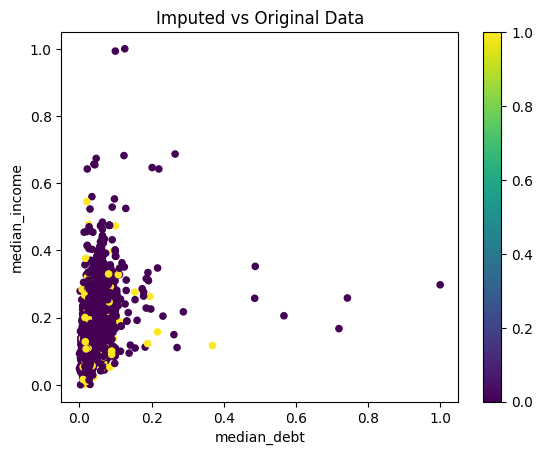

In [51]:
# Compare the imputed vs original X data
null_values = X_encode['median_debt'].isnull()
fig = X_knn_imputed.plot(x='median_debt', y = 'median_income',
                         kind='scatter', c=null_values,
                         colormap='viridis')
plt.title('Imputed vs Original Data')
plt.show()

### Multicollinearity 

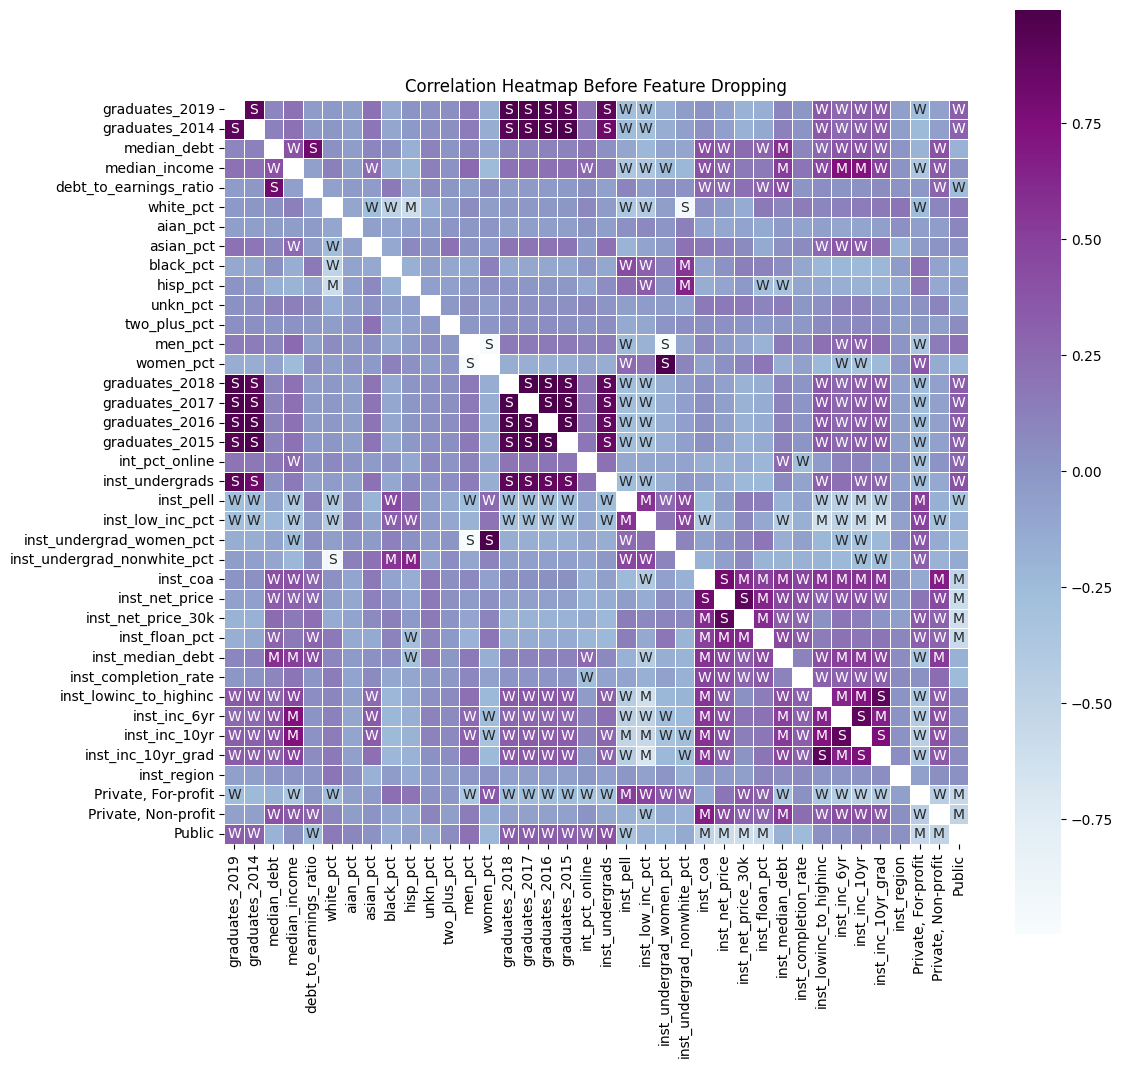

In [52]:
# Explore multicollinearity among dependent variables
df_corr = X_knn_imputed.corr(method='pearson')

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr) > 0.75, "S",
                  np.where(np.abs(df_corr) > 0.5, "M",
                           np.where(np.abs(df_corr) > 0.25, "W", "")))

# Plot the matrix
plt.figure(figsize=(12,15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)),
            square=True, center=0, annot=labels, fmt='',
            linewidth=.5, cmap='BuPu', cbar_kws={"shrink":0.8});
plt.title('Correlation Heatmap Before Feature Dropping')
plt.show()

Strong correlations among variables higher than 75%:
- graduate 2019 & graduate 2018 & graduate 2017 & graduate 2016 & graduate 2015 & graduate 2014
- inst_undergrad_women_pct & women_pct
- inst_undergrads & graduate 2014-2019
- inst_net_price & inst_coa
- inst_net_price & inst_net_price_30k
- inst_lowinc_to_highinc & inst_inc_10yr_grad
- inst_inc_6yr & inst_inc_10yr

In [53]:
# Find the highly correlated features
highly_correlated = set()

for i in range(len(df_corr.columns)):
    for j in range(i):
        if abs(df_corr.iloc[i,j]) > 0.75:
            col_name = df_corr.columns[i]
            highly_correlated.add(col_name)

# Drop the highly correlated features
X_knn_imputed.drop(highly_correlated, axis=1, inplace=True)

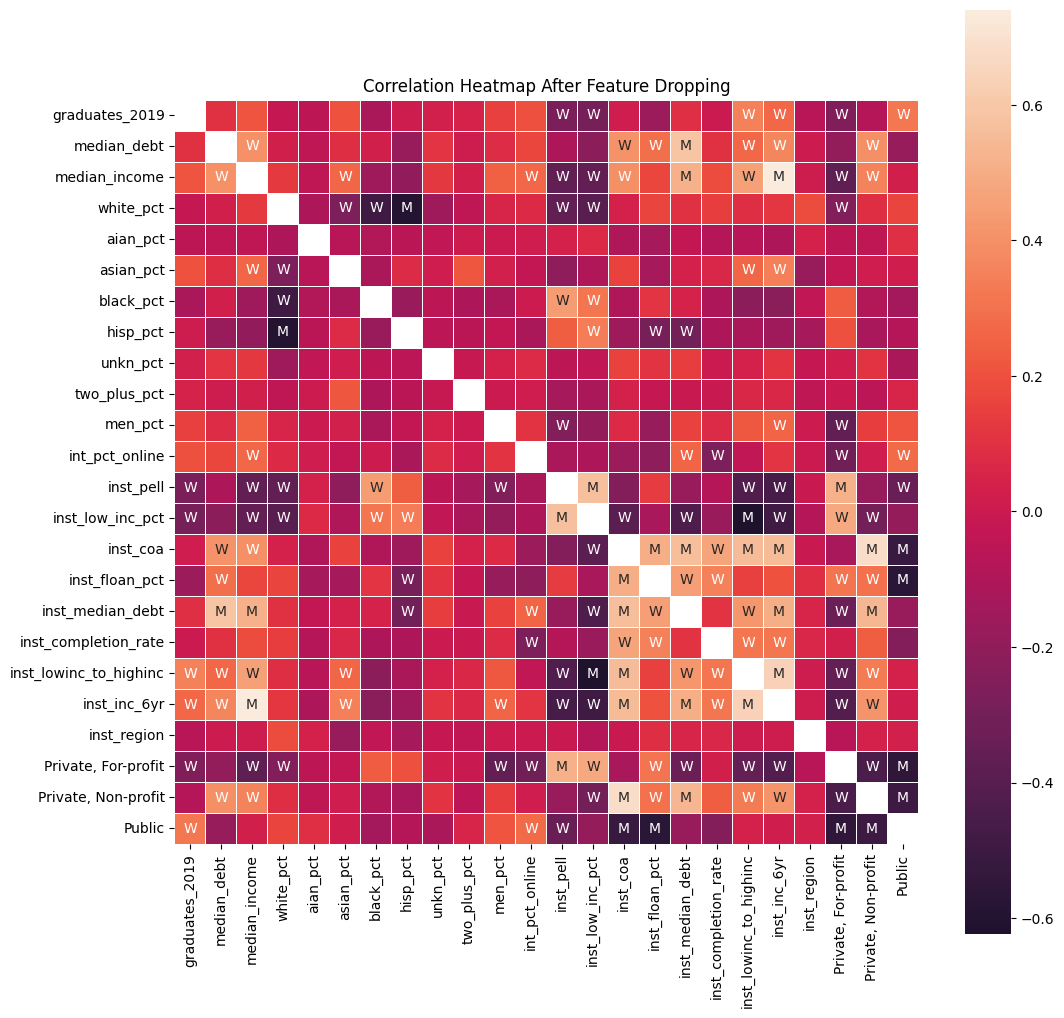

In [54]:
# Explore multicollinearity among dependent variables
df_corr = X_knn_imputed.corr(method='pearson')

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr) > 0.75, "S",
                  np.where(np.abs(df_corr) > 0.5, "M",
                           np.where(np.abs(df_corr) > 0.25, "W", "")))

# Plot the matrix
plt.figure(figsize=(12,15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)),
            square=True, center=0, annot=labels, fmt='',
            linewidth=.5, cmap='rocket', cbar_kws={"shrink":0.8})
plt.title('Correlation Heatmap After Feature Dropping')
plt.show()

In [55]:
X_knn_imputed.columns

Index(['graduates_2019', 'median_debt', 'median_income', 'white_pct',
       'aian_pct', 'asian_pct', 'black_pct', 'hisp_pct', 'unkn_pct',
       'two_plus_pct', 'men_pct', 'int_pct_online', 'inst_pell',
       'inst_low_inc_pct', 'inst_coa', 'inst_floan_pct', 'inst_median_debt',
       'inst_completion_rate', 'inst_lowinc_to_highinc', 'inst_inc_6yr',
       'inst_region', 'Private, For-profit', 'Private, Non-profit', 'Public'],
      dtype='object')

In [56]:
X_knn_imputed.shape

(4505, 24)

## Ridge Regression

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

class RidgeRegressionModel:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.best_model = None
        self.best_params = None
        self.feature_importance = None
    
    def tune_parameters(self, param_grid):
        ridge = Ridge()
        grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
        grid_search.fit(self.X_train, self.y_train)
        self.best_model = grid_search.best_estimator_
        self.best_params = grid_search.best_params_
    
    def evaluate_model(self):
        y_pred = self.best_model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(self.y_test, y_pred)
        
        print("Best Parameters:", self.best_params)
        print("Root Mean Squared Error (RMSE):", rmse)
        print("R-squared (R2):", r2)
        
        # Plotting the predicted vs. actual values with color gradient based on prediction error
        error = self.y_test - y_pred
        cmap = plt.get_cmap('coolwarm')
        sc = plt.scatter(self.y_test, y_pred, c=error, cmap=cmap)
        plt.plot([self.y_test.min(), self.y_test.max()], [self.y_test.min(), self.y_test.max()], 'k--', lw=2)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Actual vs. Predicted')
        plt.colorbar(sc, label='Prediction Error')
        plt.legend(['Data Points', 'Ideal line'])
        plt.show()
    
    def get_feature_importance(self, absolute=True):
        if self.best_model is None:
            print('Model not trained yet. Please run tune_parameters() method first.')
            return
        
        coef = self.best_model.coef_
        feature_importance = pd.Series(coef, index=self.X.columns)
        if absolute: # Option to control whether the absolute value is taken or not
            feature_importance = feature_importance.abs()
        feature_importance = feature_importance.sort_values(ascending=False)
        self.feature_importance = feature_importance
    
    def visualize_feature_importance(self):
        if self.best_model is None:
            print("Model not trained yet. Please run tune_parameters() method first.")
            return
        
        # Define a divergent color palette
        colors = sns.color_palette('RdBu', len(self.feature_importance))
        plt.figure(figsize=(12,8)) # Adjust figure size

        ax = plt.subplot(111)
        ax.bar(self.feature_importance.index, self.feature_importance.values, color=colors)
        ax.set_xticks(np.arange(len(self.feature_importance)))
        ax.set_xticklabels(self.feature_importance.index, rotation=90)
        ax.set_title('Feature Importance')
        ax.set_xlabel('Features')
        ax.set_ylabel('Coefficienct Magnitude')
        ax.axhline(y=0, color='black', linewidth=1)
        ax.set_ylim(bottom=min(self.feature_importance.values) - 0.1, top=max(self.feature_importance.values) + 0.1)

        # Add labels on top of each bar
        label_spacing = 0.02
        label_fontsize = 10
        for i, v in enumerate(self.feature_importance.values):
            ax.text(i, v + label_spacing, str(round(v,2)), ha='center', 
                    va='bottom', fontsize=label_fontsize)
        
        plt.tight_layout() # Adjusting spacing between subplots


    def show_coef(self):
        if self.best_model is None:
            print('Model is not tained yet. Please run tune_parameters() method first.')
            return
        
        coef = self.best_model.coef_
        coef_df = pd.DataFrame(coef, index=self.X.columns, columns=['Coefficient'])
        coef_df_sorted = coef_df.sort_values(by='Coefficient', ascending=False)
        return coef_df_sorted

Best Parameters: {'alpha': 0.1}
Root Mean Squared Error (RMSE): 0.037399392765297274
R-squared (R2): 0.5924063304375005


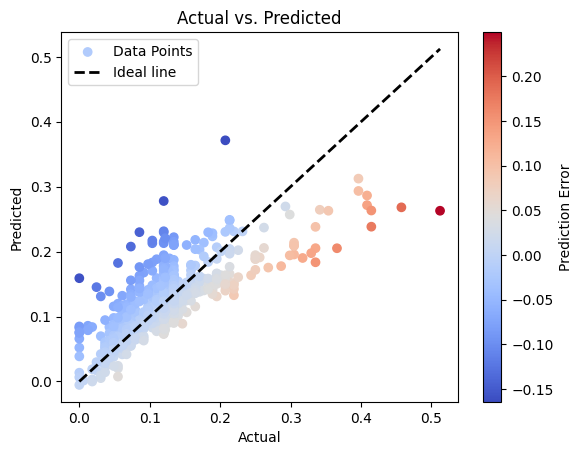

In [58]:
# Call the model
model = RidgeRegressionModel(X_knn_imputed, y_knn_imputed)

# Define the parameter grid for tuning
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}

# Perform parameter tuning
model.tune_parameters(param_grid)

# Evaluate the model
model.evaluate_model()


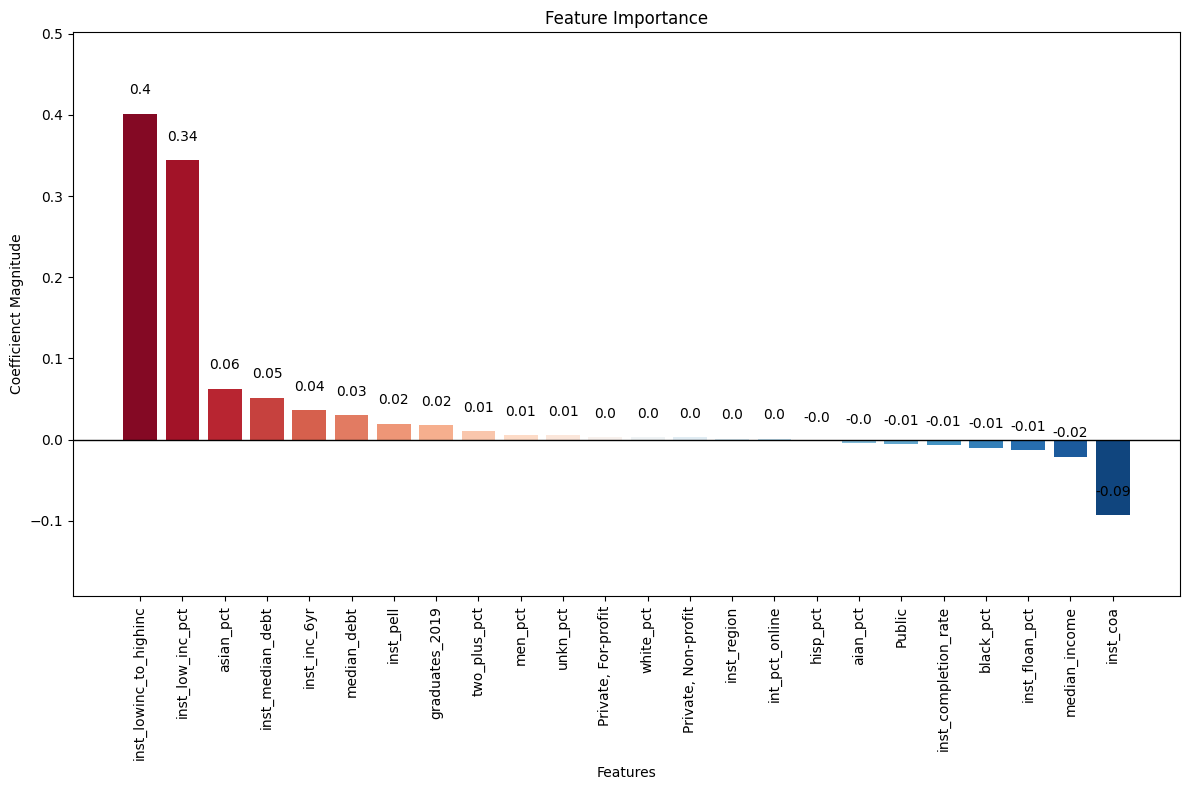

In [59]:
# Get the feature importance and visualize the result
model.get_feature_importance(absolute=False)
model.visualize_feature_importance()

In [60]:
model.show_coef()

,Coefficient
inst_lowinc_to_highinc,0.401519
inst_low_inc_pct,0.343962
asian_pct,0.062925
inst_median_debt,0.051672
inst_inc_6yr,0.036434
median_debt,0.029797
inst_pell,0.019743
graduates_2019,0.017767
two_plus_pct,0.010077
men_pct,0.005917
